## 3_nuclei_vis_function

I am attempting to combine the work from `2_explore_nuclei segmentation` which is based off Jenna Haine's `NucleiSegmentation_MIP_Dapi_Lamina` from Jenna's script`/reading_czi_stack_videos_GH/imageAnalysis_jenna/HelperFunctionsforImageProcessing.py` to combine to make an animation from the z-stacks.

### To-do
- [ ] zip together the other files too!
- [ ] Remove last scan from each czi file? Why are some of the stacks wrong?
- [ ] 


In [137]:
import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from skimage import filters, measure, segmentation, feature, img_as_ubyte, morphology
from scipy import ndimage as ndi
import pandas as pd

## Colors

from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
import matplotlib.colors


## Set where image is displayed
# matplotlib inline 
%matplotlib notebook 
#%matplotlib qt 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Part 1: Read in the files and make into one stack

In [91]:
## Read in Files
## -[ ] Make into a function, this is crazy
## 2018-10-17/dmel_st14__i_63x-08.czi and 2018-10-17/dmel_st14__i_63x-06.czi is bad

array1 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-02.czi")
#array1 = np.delete(array1, 1, axis=2)
array2 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-03.czi")
array3 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-04.czi")
array4 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-05.czi")
array5 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-07.czi")
array6 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-09.czi")

## time, channel, z-stack, y-axis, and x-axis
print(np.shape(array1))
print(np.shape(array2))
print(np.shape(array3))
print(np.shape(array4))
print(np.shape(array5))
print(np.shape(array6))

array = np.append(array1, array2, axis=2)
array = np.append(array, array3, axis=2)
array = np.append(array, array4, axis=2)
array = np.append(array, array5, axis=2)
array = np.append(array, array6, axis=2)

## Use squeeze to get rid of channels my data doesnt have.
array = array.squeeze()
print(np.shape(array))

(1, 1, 6, 2, 21, 928, 1389, 1)
(1, 1, 7, 2, 21, 928, 1389, 1)
(1, 1, 13, 2, 21, 928, 1389, 1)
(1, 1, 3, 2, 21, 928, 1389, 1)
(1, 1, 7, 2, 21, 928, 1389, 1)
(1, 1, 5, 2, 21, 928, 1389, 1)
(41, 2, 21, 928, 1389)


## Part 2: Video of just MP stacks

In [113]:
## Visualize full raw zstack
## One thing to keep in mind is that the last scan is likely always less than total
## We should drop the last z-stack = len(array)-1)
## - [ ] Is there a better way of doing this? Like do I have to have a starter array,
##       only to delete it later?

result_array =  np.zeros((1,928,1389))
type(result_array)

for i in range(1,len(array)-1):
    zstack_temp = array[i, 1, :, ...]
    result = np.expand_dims(np.max(zstack_temp, axis=0), axis = 0)
    result_array = np.append(result_array, result, axis = 0)

result_array = np.delete(result_array, 0, axis=0) # remove the empty starter array

np.shape(result_array)

(39, 928, 1389)

<IPython.core.display.Javascript object>


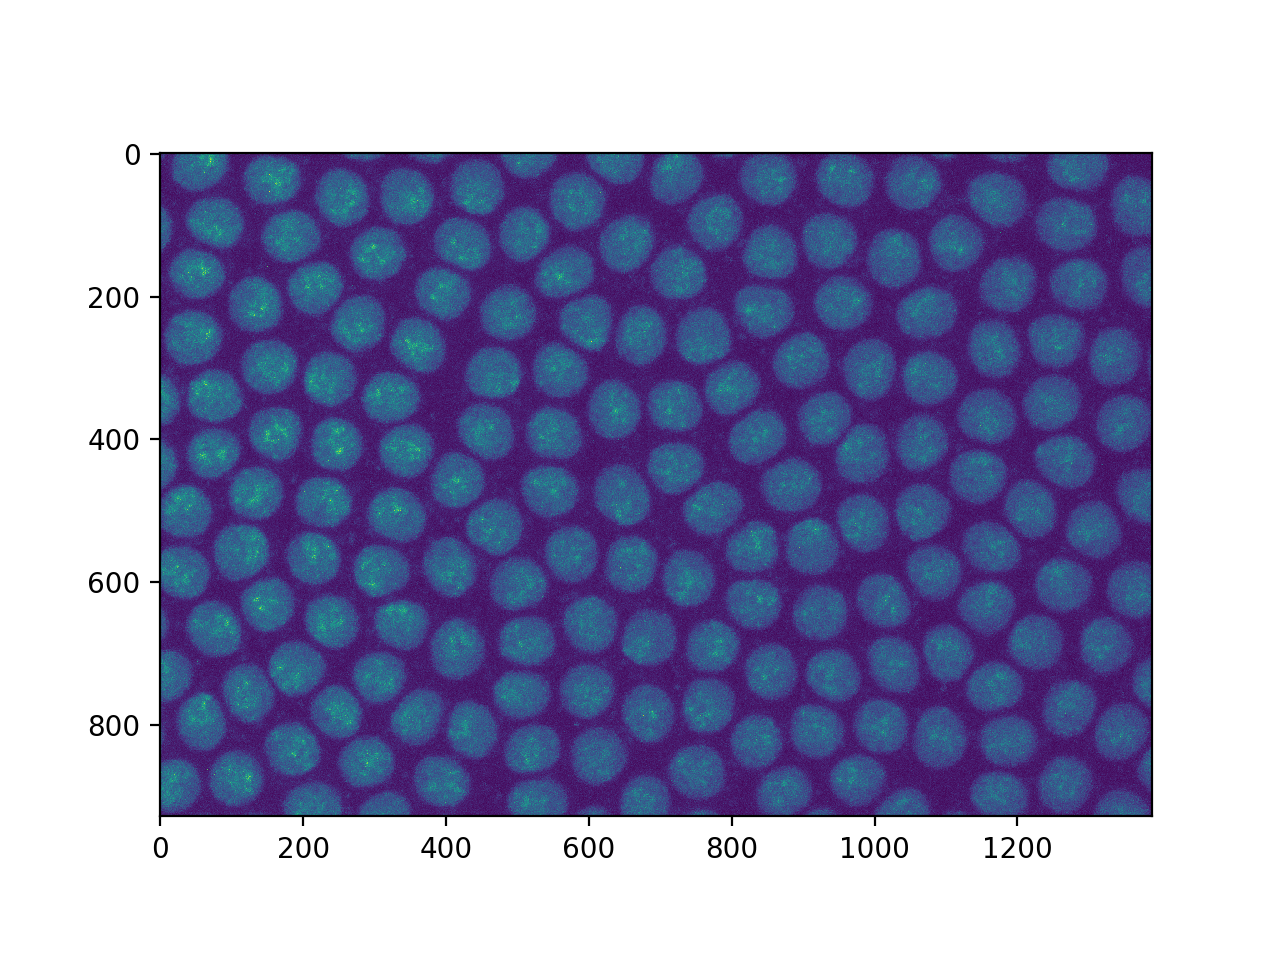

(35, 928, 1389)


In [132]:
# There are several of the stacks that are not right, but not sure why
# - [ ] Fix this

#plt.figure()
#plt.imshow(result_array2[4,:,:])

result_array2 = result_array
## Manually remove
result_array2 = np.delete(result_array2, [31], axis=0)
result_array2 = np.delete(result_array2, [24], axis=0)
result_array2 = np.delete(result_array2, [11], axis=0)
result_array2 = np.delete(result_array2, [4], axis=0)

plt.figure()
plt.imshow(result_array2[3,:,:])

print(np.shape(result_array2))

<IPython.core.display.Javascript object>


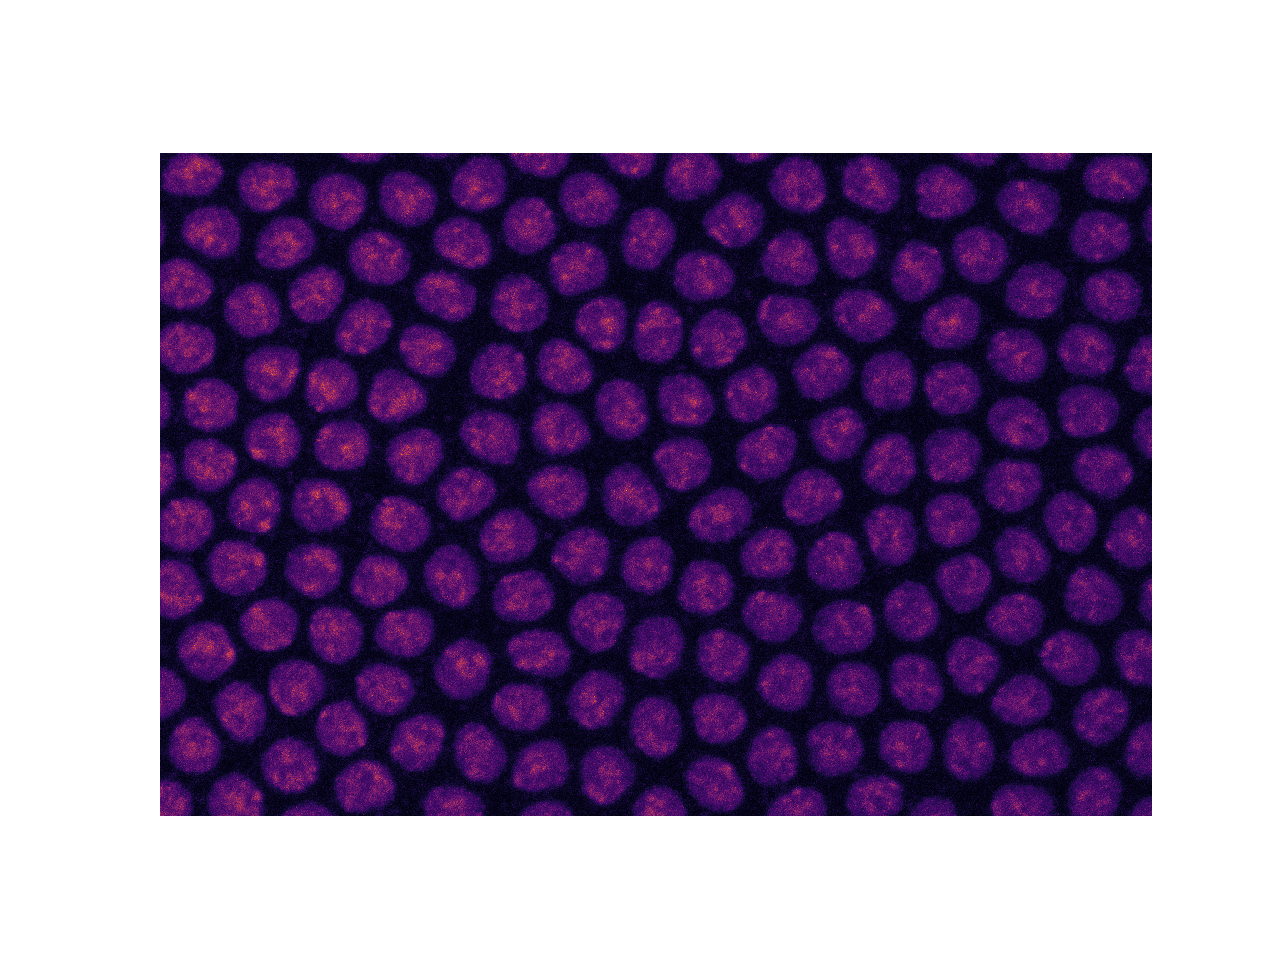

In [136]:
## go through each image in the z-stack
fig, ax = plt.subplots()
ax.axis('off') 
im = ax.imshow(result_array2[0, :, :], "inferno")

def update(i): # setting up the first image
    # Update method - What you want your figure to look like every single time
    im.set_array(result_array2[i, :, :]) 
    return [im] #returned as a iterable object as a list.
    print(im)
    # frames is how long, by specifing how many images
    
movie = animation.FuncAnimation(fig, update, interval=100, frames=result_array2.shape[0], blit=True)
plt.show()

In [96]:
## One thing to keep in mind is that the last scan is likely always less than total 
## We should drop the last z-stack = len(array)-1)

result_array =  np.zeros((1,928,1389))
type(result_array)

for i in range(1,len(array)-1):
    zstack = array[i, 1, :, ...]
    zstack_MAX = np.max(zstack, axis=0)
    zstack_MAX_8bit = img_as_ubyte(zstack_MAX)
    
    #### PART 1: Find centers with a conservative threshold
    ### First perform the conservative threshold on every point in the Z axis with the Otsu threshold
    zstack_MAX_8bit_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 1) # blur image and remove noise
    otsuthresh = filters.threshold_otsu(zstack_MAX_8bit_GausFilt) # grey scale 
    zstack_MAX_8bit_GausFilt_localtheshold = zstack_MAX_8bit_GausFilt > otsuthresh
    
    #### Then Call centers 
    ### Distance transform
    distancetransform_combined_final = ndi.distance_transform_edt(zstack_MAX_8bit_GausFilt_localtheshold)

    #### smoothen the distance transform
    distancetransform_combined_final_gaus = ndi.filters.gaussian_filter(distancetransform_combined_final, 10)
    
    #### Retrieve the local maxima from the distance transform
    ## Gives a true false for every pixel if it is the max local peak?
    Local_max = feature.peak_local_max(distancetransform_combined_final_gaus, indices = False, min_distance = 40)
    Local_max_bigger = ndi.filters.maximum_filter(Local_max, size=20)

    #makes a mask so that I can visualize on top of the original image
    Local_max_mask = np.ma.array(Local_max_bigger, mask=Local_max_bigger==0)

    #Add that mask back into the watershed image
    CenterPointArrays = Local_max_bigger
    
    #### PART 2: Now make a mask with a permissive threshold that goes all the way to the edges of the nuclei.
    image_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 20)
    localthresh = filters.threshold_local(image_GausFilt, 41)
    image_GausFilt_localtheshold = image_GausFilt > localthresh
    image_GausFilt_localtheshold_dilate = morphology.binary_dilation(image_GausFilt_localtheshold)
    EdgeMask = image_GausFilt_localtheshold_dilate
    EdgeMask_gauss = ndi.filters.gaussian_filter(EdgeMask, .5) ## Smooth
    
    result = np.expand_dims(EdgeMask_gauss, axis=0)
    result_array = np.append(result_array, result, axis = 0)

result_array = np.delete(result_array, 0, axis=0) # remove the emmpty starter array


/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


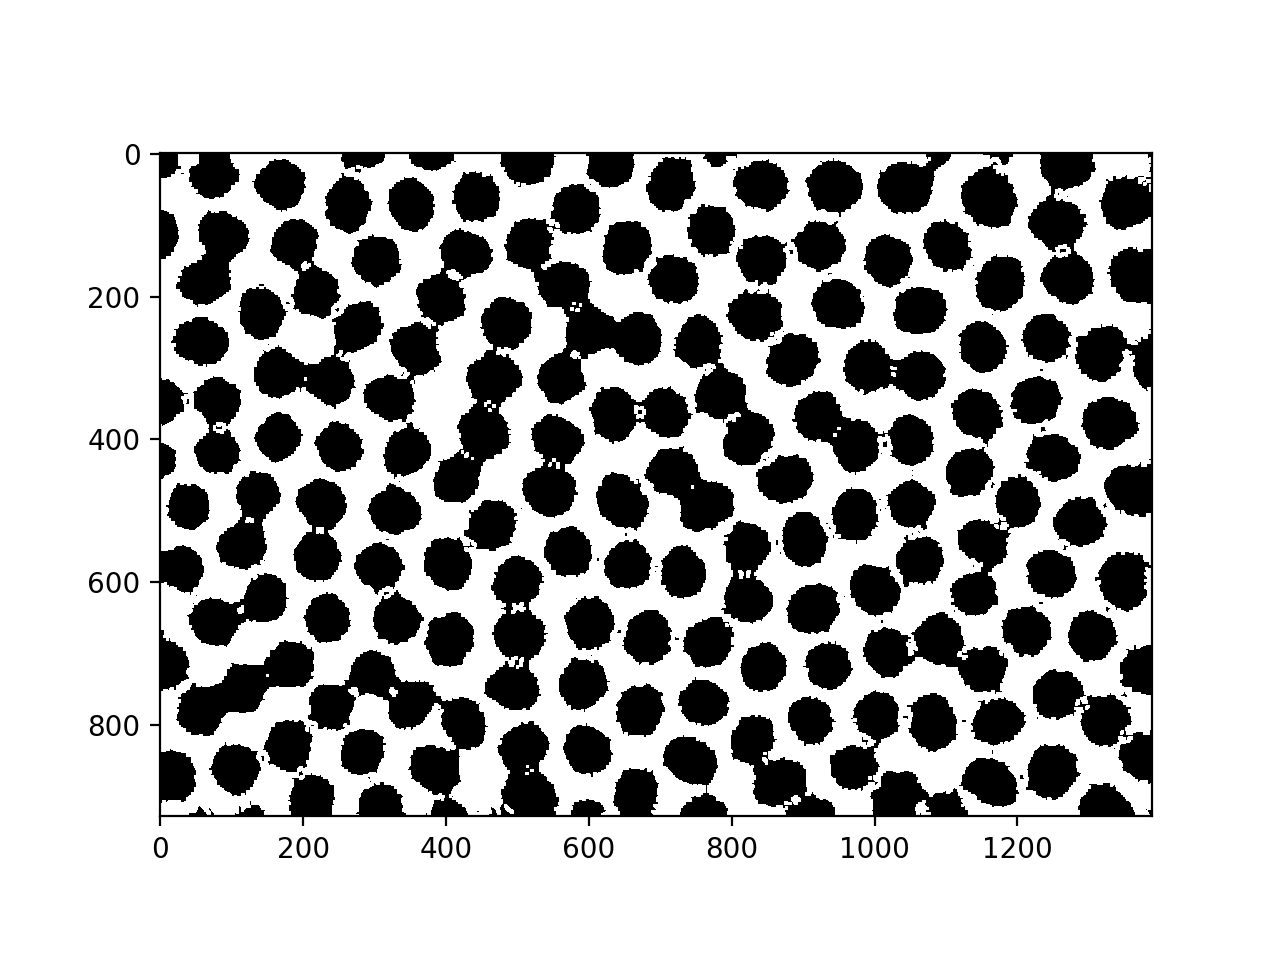

(39, 928, 1389)

In [98]:
#result_array
plt.figure()
plt.imshow(result_array[0,:,:], "Greys")

np.shape(result_array)

<IPython.core.display.Javascript object>


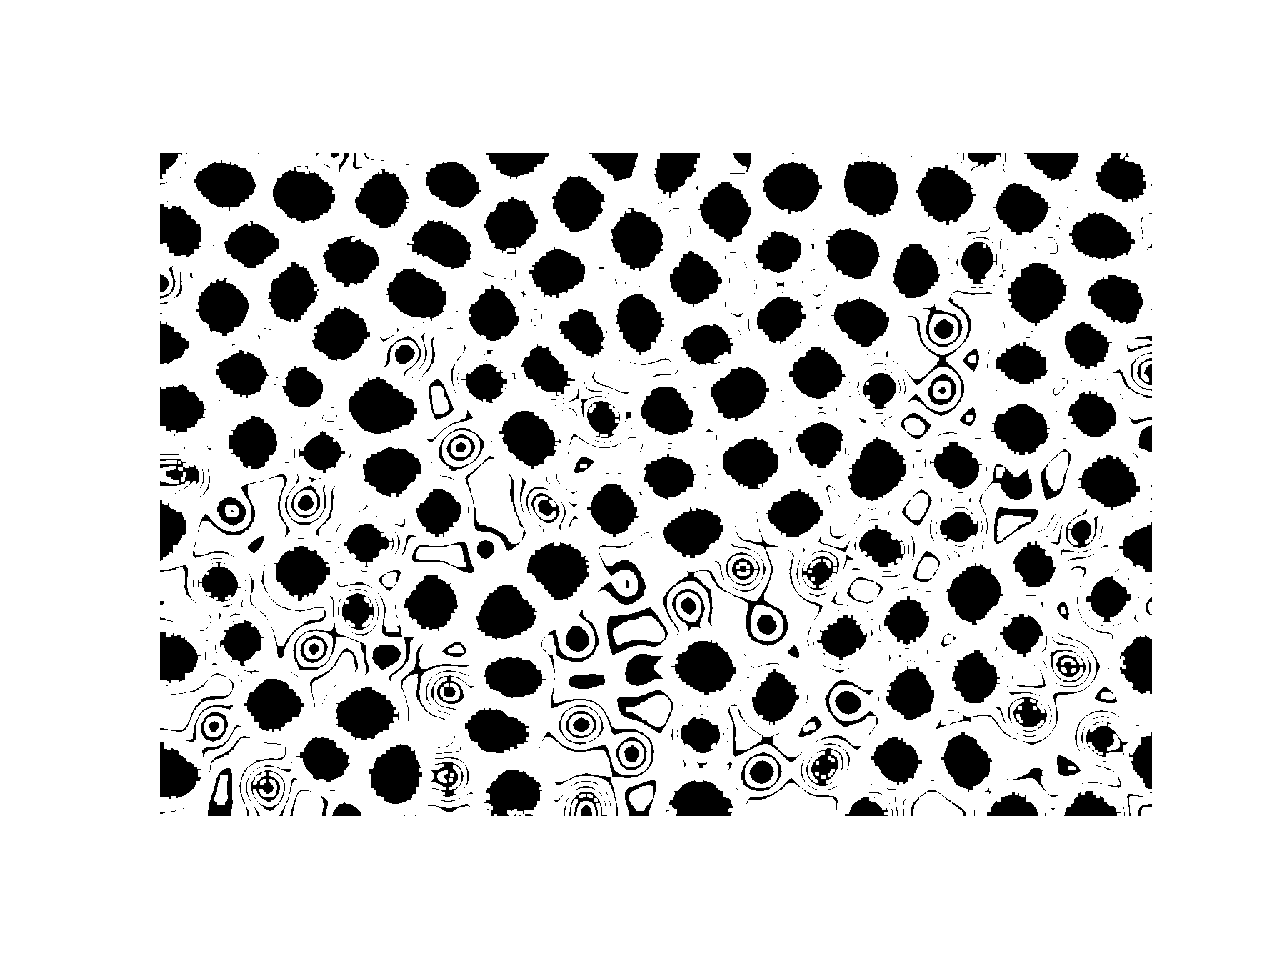

In [100]:
## go through each image in the z-stack

fig, ax = plt.subplots()
ax.axis('off') 
im = ax.imshow(result_array[0, :, :],"Greys")

def update(i): # setting up the first image
    im.set_array(result_array[i, :, :]) 
    return [im]
    print(im)
    
    
movie = animation.FuncAnimation(fig, update, interval=200, frames=result_array.shape[0], blit=True)
plt.show()

In [56]:
im